In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../2. Data Cleaning/cleaned_ads.csv')

In [3]:
df.head()

,link,title,address,region,area,age,rooms,total_price,price_per_meter,floor,elevator,parking,warehouse,longitude,latitude
0,https://divar.ir/v/-/wZmAzMs2,۹۵متر/ فول امکانات / فول بازسازی,ایران,12,95,1383,2,8000000000,84210000,3,True,True,True,51.444726,35.684725
1,https://divar.ir/v/-/wZl0tBJo,اپارتمان۵۰متر۱خواب نوسازتکواحدی گیلکی آهنگ مینا,مینا,14,50,1403,1,4400000000,88000000,3,True,True,False,51.449087,35.670433
2,https://divar.ir/v/-/wZmcALyN,۱۱۵ متر دوخواب شیک و...,یوسف‌آباد,6,115,1398,2,15890000000,138173000,4,True,True,True,NaN,NaN
3,https://divar.ir/v/-/wZgQZf-8,تکواحدی با پارکینگ,شهرک ولیعصر,4,51,1390,1,2000000000,39215000,2,False,True,True,51.345065,35.648787
4,https://divar.ir/v/-/wZXc6Q-z,نیاوران ۳۵۰ متر/سه جهت نور گیر/۴تراس,نیاوران,1,350,1390,4,52800000000,150857000,5,True,True,True,51.452451,35.812732


Since we're going to use the final dataset to train our models, let's get rid of the unnecessary columns.

In [4]:
exclude_cols = ['link', 'title', 'price_per_meter', 'longitude', 'latitude']
df.drop(exclude_cols, axis=1, inplace=True)

In [5]:
df.head()

,address,region,area,age,rooms,total_price,floor,elevator,parking,warehouse
0,ایران,12,95,1383,2,8000000000,3,True,True,True
1,مینا,14,50,1403,1,4400000000,3,True,True,False
2,یوسف‌آباد,6,115,1398,2,15890000000,4,True,True,True
3,شهرک ولیعصر,4,51,1390,1,2000000000,2,False,True,True
4,نیاوران,1,350,1390,4,52800000000,5,True,True,True


In [6]:
df.select_dtypes(include=['float64', 'int64']).skew()

region          0.894926
area           97.236533
age            -0.553435
rooms           0.334883
total_price    19.799423
floor           3.610287
dtype: float64

The highly skewed features are area and total_price, possibly due to outliers which we'll get to later.
Floor is also skewed but not as much as the other two. What to do with it?
In the EDA step, we saw that the correlation of floor and total_price is 0.064 which is very low. But A low correlation might mask non-linear relationships. Let's plot floor against total_price to see if there's a pattern.

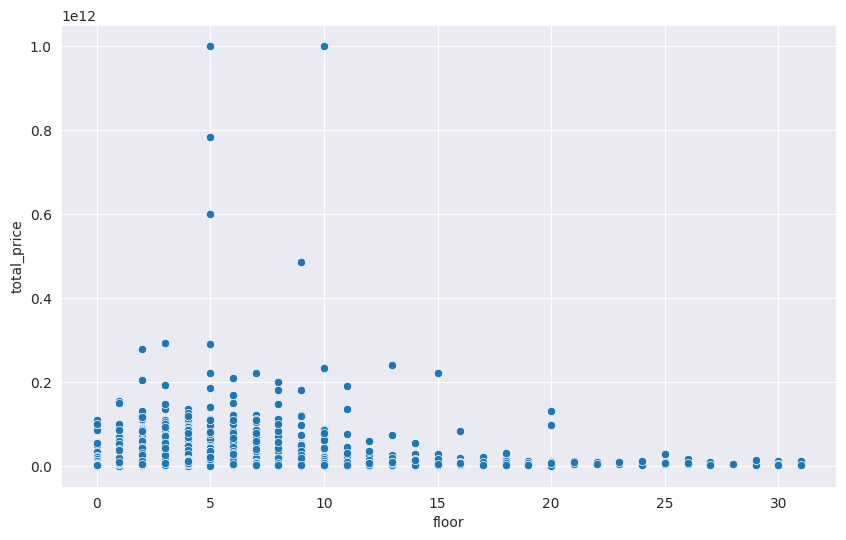

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='floor', y='total_price', data=df)
plt.show()

There doesn't seem to be a pattern. Let's try binning the floor feature, and then see how the correlation changes.

In [8]:
df['floor_category'] = pd.cut(df['floor'], bins=[0, 5, 10, 20, np.inf], labels=[0, 1, 2, 3])

In [9]:
df.sample(5)

,address,region,area,age,rooms,total_price,floor,elevator,parking,warehouse,floor_category
2304,گیشا (کوی نصر),2,100,1390,3,15000000000,4,True,True,True,0
285,جنت‌آباد شمالی,5,63,1385,2,5280000000,1,False,True,True,0
6701,دولاب,14,55,1385,1,2370000000,4,False,True,True,0
2594,سلسبیل,10,60,1384,2,3900000000,3,False,True,True,0
7624,پونک,2,64,1398,1,6500000000,4,True,True,True,0


In [10]:
# correlation of floor_category and total_price
df['floor_category'].corr(df['total_price'])

0.030241076837049713

The correlation is still very low. We can drop the floor feature since it has no predictive power.

In [11]:
df.drop('floor', axis=1, inplace=True)
df.drop('floor_category', axis=1, inplace=True)

In [12]:
df.head()

,address,region,area,age,rooms,total_price,elevator,parking,warehouse
0,ایران,12,95,1383,2,8000000000,True,True,True
1,مینا,14,50,1403,1,4400000000,True,True,False
2,یوسف‌آباد,6,115,1398,2,15890000000,True,True,True
3,شهرک ولیعصر,4,51,1390,1,2000000000,False,True,True
4,نیاوران,1,350,1390,4,52800000000,True,True,True


All right. Back to the skewness issue. Let's visualize the distribution of the area and total_price features.

Violin plots

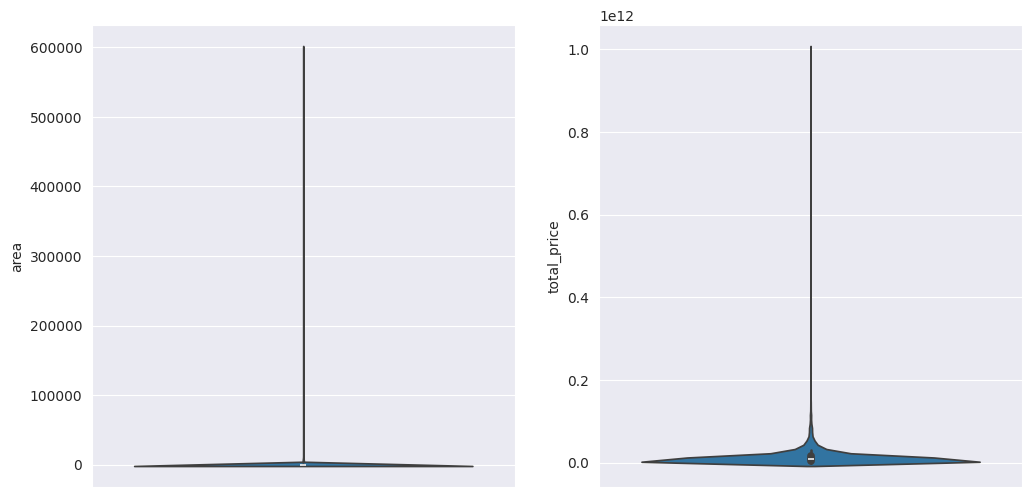

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.violinplot(y=df['area'])
plt.subplot(1, 2, 2)
sns.violinplot(y=df['total_price'])
plt.show()

histograms

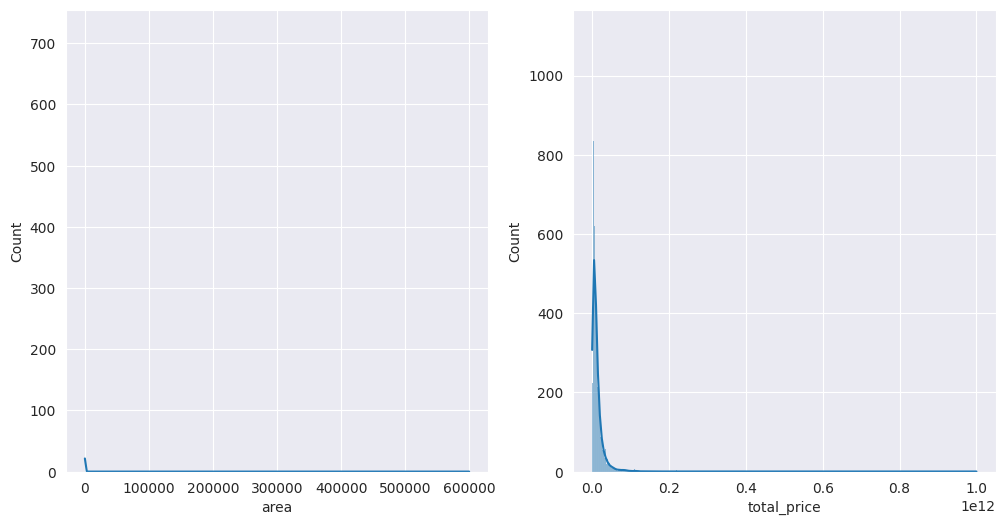

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['area'], kde=True)
plt.subplot(1, 2, 2)
sns.histplot(df['total_price'], kde=True)
plt.show()

Finding the outliers

In [15]:
def find_limits(x):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    return lower_limit, upper_limit

In [16]:
area_lower_limit, area_upper_limit = find_limits(df['area'])
price_lower_limit, price_upper_limit = find_limits(df['total_price'])

area_lower_limit, area_upper_limit, price_lower_limit, price_upper_limit

(-25.5, 210.5, -12750000000.0, 31650000000.0)

In [17]:
area_outliers = np.where(df['area'] > area_upper_limit)
price_outliers = np.where(df['total_price'] > price_upper_limit)
all_outliers = np.union1d(area_outliers, price_outliers)

print(f'Number of area outliers: {area_outliers[0].shape[0]}')
print(f'Number of price outliers: {price_outliers[0].shape[0]}')
print(f'Number of all outliers: {all_outliers.shape[0]}')

Number of area outliers: 373
Number of price outliers: 726
Number of all outliers: 778


In [18]:
# get the info of outliers
df.iloc[all_outliers].describe()

,region,area,age,rooms,total_price
count,778.000000,778.000000,778.000000,778.000000,7.780000e+02
mean,3.730077,1086.598972,1396.604113,3.192802,5.931322e+10
std,5.577962,21546.157614,7.627262,0.612062,6.950122e+10
min,1.000000,17.000000,1370.000000,0.000000,1.111110e+05
25%,1.000000,177.000000,1393.000000,3.000000,3.500000e+10
50%,2.000000,210.000000,1400.000000,3.000000,4.385500e+10
75%,3.000000,250.000000,1403.000000,3.000000,6.207500e+10
max,22.000000,600000.000000,1403.000000,5.000000,1.000000e+12


<Axes: xlabel='region'>

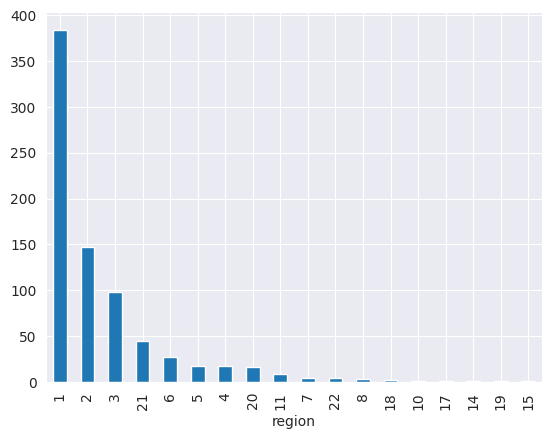

In [19]:
# analyze the region of the outliers
df.iloc[all_outliers]['region'].value_counts().sort_values(ascending=False).plot(kind='bar')

How many properties are in region 1 in total?

In [20]:
df['region'].value_counts()

region
5     1361
2     1337
10     990
4      779
1      769
21     548
3      520
6      416
8      366
7      350
15     321
11     289
18     268
22     263
9      236
20     179
14     175
13     131
16      82
17      76
19      68
12      53
Name: count, dtype: int64

So about half of region 1's properties are outliers!

A new dataframe to analyze the outliers

In [21]:
normal_df = df.drop(all_outliers)
normal_df.head()

,address,region,area,age,rooms,total_price,elevator,parking,warehouse
0,ایران,12,95,1383,2,8000000000,True,True,True
1,مینا,14,50,1403,1,4400000000,True,True,False
2,یوسف‌آباد,6,115,1398,2,15890000000,True,True,True
3,شهرک ولیعصر,4,51,1390,1,2000000000,False,True,True
5,یوسف‌آباد,6,161,1370,3,14570000000,False,False,False


In [22]:
# check the skewness
normal_df.select_dtypes(include=['float64', 'int64']).skew()

region         0.850212
area           0.756343
age           -0.499719
rooms          0.129376
total_price    1.106320
dtype: float64

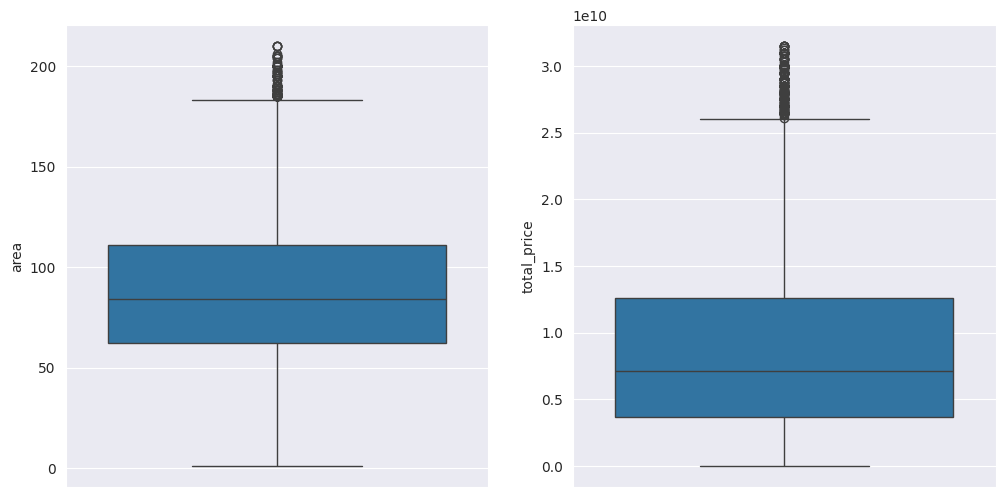

In [23]:
# check the distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=normal_df['area'])
plt.subplot(1, 2, 2)
sns.boxplot(y=normal_df['total_price'])
plt.show()

In [24]:
df.shape, normal_df.shape

((9577, 9), (8799, 9))

Because about 8% of the data is considered outliers, and they're all valid data points (luxury properties), we'll keep them in the dataset. We can have two more columns: 1. log transformation of the total_price feature 2. a categorical variable indicating whether the property is an outlier or not.

In [25]:
df['total_price_log'] = np.log1p(df['total_price'])
df['outlier'] = 0
df.loc[all_outliers, 'outlier'] = 1

df.head()

,address,region,area,age,rooms,total_price,elevator,parking,warehouse,total_price_log,outlier
0,ایران,12,95,1383,2,8000000000,True,True,True,22.802707,0
1,مینا,14,50,1403,1,4400000000,True,True,False,22.204870,0
2,یوسف‌آباد,6,115,1398,2,15890000000,True,True,True,23.488956,0
3,شهرک ولیعصر,4,51,1390,1,2000000000,False,True,True,21.416413,0
4,نیاوران,1,350,1390,4,52800000000,True,True,True,24.689777,1


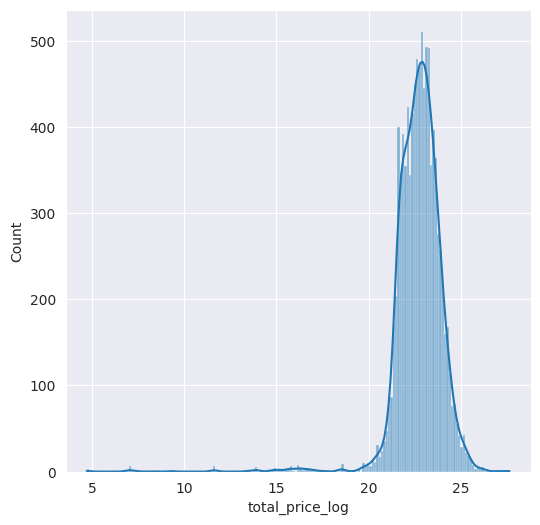

In [26]:
# plot the distribution of the log-transformed total_price
plt.figure(figsize=(6, 6))
sns.histplot(df['total_price_log'], kde=True)
plt.show()

Next step? Encoding the addresses. Since there are about 320 unique addresses, we can't use one-hot encoding. We can use target encoding or mean encoding.

In [27]:
df['address'].nunique()

319

In [28]:
# Compute global mean of the target (price)
global_mean = df['total_price'].mean()
# Calculate the mean price per address
mean_per_address = df.groupby('address')['total_price'].mean()
# Calculate the count of each address (to help with smoothing)
count_per_address = df.groupby('address')['total_price'].count()

Apply smoothing: (count / (count + smoothing_factor)) * (address_mean) + (smoothing_factor / (count + smoothing_factor)) * global_mean

In [29]:
smoothing_factor = 5
smoothed_encoding = (count_per_address / (count_per_address + smoothing_factor)) * mean_per_address + \
                     (smoothing_factor / (count_per_address + smoothing_factor)) * global_mean

# Map the smoothed encoding to the original data
df['address_encoded'] = df['address'].map(smoothed_encoding)

df.sample(5)

,address,region,area,age,rooms,total_price,elevator,parking,warehouse,total_price_log,outlier,address_encoded
6743,سازمان برنامه,5,55,1394,1,6250000000,True,True,True,22.555847,0,9.229361e+09
5647,شهرک شهید باقری,22,83,1384,2,4650000000,False,False,True,22.260133,0,7.549618e+09
6680,میرداماد,3,110,1385,2,15550000000,True,True,True,23.467326,0,2.147092e+10
700,تهرانپارس غربی,4,55,1393,1,5400000000,True,True,True,22.409665,0,9.962708e+09
8125,شهرک غرب,2,154,1385,3,18500000000,True,True,True,23.641037,0,2.505148e+10


In [30]:
df.drop('address', axis=1, inplace=True)

In [31]:
df.sample(5)

,region,area,age,rooms,total_price,elevator,parking,warehouse,total_price_log,outlier,address_encoded
3146,11,100,1403,2,1800000000,True,True,True,21.311053,0,1.296228e+10
1218,2,72,1385,1,7400000000,False,True,True,22.724746,0,1.115059e+10
1288,5,105,1397,2,12600000000,True,True,True,23.256963,0,1.233031e+10
5174,5,60,1385,1,5000000000,False,False,True,22.332704,0,9.603830e+09
2236,8,78,1402,2,9700000000,True,True,True,22.995392,0,8.752979e+09


In [32]:
df.to_csv('preprocessed_ads.csv', index=False)

In [33]:
normal_df.to_csv('preprocessed_ads_no_outliers.csv', index=False)